# Setup

In [17]:
# Imports
import os
import sklearn as skl
import numpy as np
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-17"
os.environ["PYSPARK_PYTHON"] = r"C:\Users\rmcne\AppData\Local\Programs\Python\Python311\python.exe"

# I'm working across multiple devices. So, this code will always create a path to the folder containing the data.
data_folder_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "instacart-market-basket-analysis")
data_folder_path

sc = pyspark.SparkContext()  # instantiate pyspark connection

spark = SparkSession.builder.appName("CSC84040_assignment1").getOrCreate() # instantiate spark entry point

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at C:\Users\rmcne\AppData\Local\Temp\ipykernel_6704\3235860617.py:18 

# Part A: Exploratory Data Analysis
1. Perform Exploratory Data Analysis (EDA) and discuss the data and what you observe
prior to beginning modeling and how the EDA insights impact how to proceed 

### Aisles

In [20]:
aisles = pd.read_csv(os.path.join(data_folder_path, "aisles.csv"))

In [21]:
print(f"No duplicate aisles: {len(pd.unique(aisles.aisle)) == len(aisles.aisle)}")

print(f"NA values: {aisles.isnull().sum().sum()}")

aisles.head()

No duplicate aisles: True
NA values: 0


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


Aisles appears to be a table of aisles (by name (str)) with unique id numbers assigned to each.

### Departments

In [22]:
departments = pd.read_csv(os.path.join(data_folder_path, "departments.csv"))

In [23]:
print(f"Unique departments {departments.__len__()}") # here len = nunique departments so long as duplicates == 0
print(f"No duplicate departments: {len(pd.unique(departments.department)) == len(departments.department)}")
print(f"NA values: {departments.isnull().sum().sum()}")

departments.head()

Unique departments 21
No duplicate departments: True
NA values: 0


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


Departments appears to be a table of departments (by name (str)) with unique id numbers assigned to each.

### Order_products__prior

In [24]:
order_products__prior = pd.read_csv(os.path.join(data_folder_path, "order_products__prior.csv"))
order_products__prior.__len__()

32434489

In [25]:
print(f"NA values: {order_products__prior.isnull().sum().sum()}")

print(f"Unique orders in dataset: {order_products__prior.order_id.nunique()}")

print(f"Frequency of reorder: {round(order_products__prior.reordered.mean(), 4) * 100}%")

order_products__prior.head()

NA values: 0
Unique orders in dataset: 3214874
Frequency of reorder: 58.97%


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


order_products__prior appears to be a table of products previously ordered by order (for ~3.4 million orders), including the order in which each product was added to cart & a binary flag for whether that product was previously ordered by that customer.

Median add_to_cart_order: 6.0


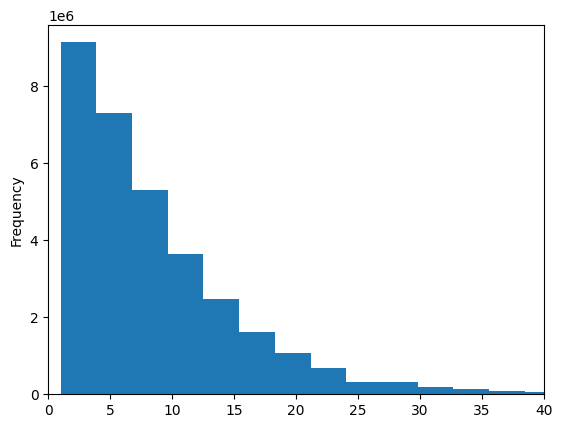

In [26]:
print(f"Median add_to_cart_order: {order_products__prior['add_to_cart_order'].median()}")
order_products__prior['add_to_cart_order'].plot.hist(bins=50)
plt.xlim(0, 40)
plt.show()

The max add_to_cart order is 145, but there are several outliers, so I clip my graph at 40 to see where most rows fall. The frequency of add_to_cart_order values seems to drop quickly. 
Given these outliers, I also look at the median instead of the mean. This shows that "most" items are added to an order in position 6 or less.

In [27]:
print(f"Median number of orders containing each product: {order_products__prior['product_id'].value_counts().median()}")
order_products__prior['product_id'].value_counts().sort_index()

Median number of orders containing each product: 60.0


product_id
1        1852
2          90
3         277
4         329
5          15
         ... 
49684       9
49685      49
49686     120
49687      13
49688      89
Name: count, Length: 49677, dtype: int64

Value counts of product_id shows that most products are represented in 60 or fewer orders, however a few products are extreme outliers. These may need to be dropped to produce a strong predictive model.

### Order_products__train

In [28]:
order_products__train = pd.read_csv(os.path.join(data_folder_path, "order_products__train.csv"))

In [29]:
print(f"NA values: {order_products__train.isnull().sum().sum()}")

print(f"Orders in dataset: {order_products__train.order_id.nunique()}")

print(f"Frequency of reorder: {round(order_products__train.reordered.mean(), 4) * 100}%")

print(f"Comparative size: {round((order_products__train.__len__() / order_products__prior.__len__()) * 100, 2)}%")

order_products__train.head()

NA values: 0
Orders in dataset: 131209
Frequency of reorder: 59.86%
Comparative size: 4.27%


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


order_products__train appears to be a training set of data of the same structure as order_produces_prior, but only contains 4.27% as much data. 

### Orders

In [30]:
orders = pd.read_csv(os.path.join(data_folder_path, "orders.csv"))

In [31]:
print(f"NA values: {orders.isnull().sum().sum()}")
print(f"Proportion of NAs {round(100 * orders.isnull().sum().sum()/orders.__len__(), 2)}%")
print(f"Orders in dataset: {orders.order_id.nunique()}")
print(f"Duplicate orders: {orders['order_id'].duplicated().sum()}")
orders[orders['days_since_prior_order'].isna()]

NA values: 206209
Proportion of NAs 6.03%
Orders in dataset: 3421083
Duplicate orders: 0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
11,2168274,2,prior,1,2,11,NaN
26,1374495,3,prior,1,1,14,NaN
39,3343014,4,prior,1,6,11,NaN
45,2717275,5,prior,1,3,12,NaN
...,...,...,...,...,...,...,...
3420930,969311,206205,prior,1,4,12,NaN
3420934,3189322,206206,prior,1,3,18,NaN
3421002,2166133,206207,prior,1,6,19,NaN
3421019,2227043,206208,prior,1,1,15,NaN


In [32]:
orders[(orders['days_since_prior_order'].isna()) & (orders['eval_set'] != 'prior')].sum().sum()
# filter for days_since_prior_order is na & eval_set not 'prior'

np.float64(0.0)

All rows containing NAs are apparently part of the 'prior' set. No NAs (from this file, at least) in the train or test sets.

In [33]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


Orders contains items ordered categorized into the "prior" (previous orders), training & testing datasets, plus features for "order_number", day of the week when an order was placed, hour it was placed, and days since prior order. No duplicate order IDs, one row per order. Days since prior order contains about 6% NAs, presumably orders with no prior order. The maximum value for days_since_prior_order is 30. I'm curious why. Have values greater than 30 have been squished to 30? Have those rows been dropped? are those the NAs?

### Products

In [34]:
products = pd.read_csv(os.path.join(data_folder_path, "products.csv"))

In [35]:
print(f"NA values: {products.isnull().sum().sum()}")
print(f"Products in dataset: {products.product_id.nunique()}")
print(f"Duplicate products: {products['product_id'].duplicated().sum()}")
products.head()

NA values: 0
Products in dataset: 49688
Duplicate products: 0


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Products contains information about each product, assigning a unique ID number to each product, along with the aisle & department where it can be located. There are just under 50,000 unique products in our data.

### Sample_submission

In [36]:
sample_submission = pd.read_csv(os.path.join(data_folder_path, "sample_submission.csv"))

In [37]:
sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


This is a sample submission. For each order_id, there are space-separated pairs of previously ordered products (by product_id) most likely to be in a user's next order.

2. Pre-processed data for use in the model and justify pre-processing methods. Note this
may be different for each Part and/or algorithm you try. 

Load order_products__prior as RDD

In [38]:
OPP_lines = sc.textFile(os.path.join(data_folder_path, 'order_products__prior.csv'))
OPP_baskets = OPP_lines.map(lambda l: l.split(','))
OPP_N = OPP_baskets.count()
print("N:", OPP_N)  # Length matches length when loaded with pd. Evidence that the data was loaded correctly.
OPP_header = OPP_baskets.first()  # Save header
OPP_baskets = OPP_baskets.filter(lambda row: row != OPP_header)  # Remove header row from rdd
OPP_baskets.take(5)

N: 32434490


[['2', '33120', '1', '1'],
 ['2', '28985', '2', '1'],
 ['2', '9327', '3', '0'],
 ['2', '45918', '4', '1'],
 ['2', '30035', '5', '0']]

Load products as RDD

In [39]:
products_lines = sc.textFile(os.path.join(data_folder_path, 'products.csv'))
products_baskets = products_lines.map(lambda l: l.split(',')).map(lambda row: (row[0], row[1]))
products_N = products_baskets.count()
print("N:", OPP_N)  # Length matches length when loaded with pd. Evidence that the data was loaded correctly.
products_header = products_baskets.first()  # Save header
products_baskets = products_baskets.filter(lambda row: row != products_header)  # Remove header row from rdd
products_baskets.take(5)

N: 32434490


[('1', 'Chocolate Sandwich Cookies'),
 ('2', 'All-Seasons Salt'),
 ('3', 'Robust Golden Unsweetened Oolong Tea'),
 ('4', 'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce'),
 ('5', 'Green Chile Anytime Sauce')]

Create a dictionary of product_id to product_name for later use

In [48]:
product_id_to_name = dict(zip(products['product_id'], products['product_name']))

# Part B: Association Rules
Use “order_products__prior.csv” to build frequent itemsets and association rules to understand
what products are often bought together. Also, use your findings to understand what drives
market baskets and association rules that are indicative of large lemon purchases. Please provide
commentary and rationale for everything you are doing.

First, calculate product frequencies. These are counts of the number of times an item occurs in the entire dataset. 

This will be necessary for calculating the support of each item set and association rules.

product_counts == singles_support from notes.


In [58]:
# Product counts
# Count 1 for each item occurrence
product_counts = OPP_baskets.map(lambda row: (row[1], 1))

# Sum total occurrences of each item
product_counts = product_counts.reduceByKey(lambda x, y: x + y)

# Filter out infrequent items
product_counts = product_counts.filter(lambda x: x[1] >= 100)

product_counts.take(5)

[('24838', 49569),
 ('38693', 4529),
 ('23423', 2415),
 ('26910', 463),
 ('9848', 101)]

For later transformations, collect product_counts into a dict.

In [64]:
product_counts = dict(product_counts.collect())

AttributeError: 'dict' object has no attribute 'collect'

For inspection, produce sorted df.

In [50]:
# Collect to pd.df for inspection
product_counts_df = spark.createDataFrame(product_counts, schema=["product_id", "count"]).toPandas()

# Correct types
product_counts_df['product_id'] = product_counts_df['product_id'].astype(int)

#  Merge with products on product_id to get product_name 
product_counts_df = pd.merge(product_counts_df, products[['product_id', 'product_name']], on='product_id', how='inner')

# I just want name & count for inspection
product_counts_df = product_counts_df[['product_name', 'count']]

# Sort descending by count
product_counts_df.sort_values(by='count', ascending=False, inplace=True)

# Top 10 most frequently purchased items
product_counts_df[:10]

,product_name,count
16765,Banana,472565
6765,Bag of Organic Bananas,379450
7923,Organic Strawberries,264683
16763,Organic Baby Spinach,241921
11220,Organic Hass Avocado,213584
5679,Organic Avocado,176815
5685,Large Lemon,152657
15677,Strawberries,142951
18946,Limes,140627
4535,Organic Whole Milk,137905


The most commonly purchased items appear to be among fresh fruit & vegetables.

Next, calculate product pair frequencies. This will be used for calculating association rules.

In [51]:
# Product pair counts
# Create (order_id, product_id) tuples
orders_to_products = OPP_baskets.map(lambda row: (row[0], row[1]))

# Group by order_id
order_product_baskets = orders_to_products.groupByKey().map(lambda x: list(set(x[1])))  

def generate_pairs(basket):  # Generates product pairs
    pairs = []
    n = len(basket)
    # For each product in the basket, pair with every product that comes after it (avoids duplicate pairs)
    for i in range(n):
        for j in range(i + 1, n):
            pairs.append((basket[i], basket[j]))
    return pairs

# Generate all pairs for each basket
product_pairs = order_product_baskets.flatMap(generate_pairs)

# Count the occurrences of each pair
pair_counts = product_pairs.map(lambda pair: (pair, 1))

# Sum total occurrences of each pair
pair_counts = pair_counts.reduceByKey(lambda x, y: x + y)

# Filter out infrequent pairs
pair_counts = pair_counts.filter(lambda x: x[1] >= 100)

pair_counts.take(5)

[(('47766', '43394'), 344),
 (('28849', '37766'), 167),
 (('28849', '10017'), 351),
 (('7751', '5212'), 105),
 (('10749', '44632'), 1569)]

pair_counts == doubles_support form notes.

For inspection, transform the RDD to have three elements: item_1, item_2, count

In [52]:
# Widen to 3-tuple
pair_counts_wide = pair_counts.map(lambda x: (x[0][0], x[0][1], x[1]))

# Make item_1 key for the purpose of joining
pair_counts_wide_names = pair_counts_wide.map(lambda x: (x[0], (x[1], x[2])))
# Results in shape (item_1, (item_2, count))

# Join to get product_name for item_1
pair_counts_wide_names = pair_counts_wide_names.join(products_baskets)
# Results in shape (item_1, ((item_2, count), product_name_1))

# Map result to get the product_name for item_1
pair_counts_wide_names = pair_counts_wide_names.map(lambda x: (x[1][0][0], (x[1][1], x[1][0][1])))
# Results in shape (item_2, (product_name_1, count))

# Join for item_2
pair_counts_wide_names = pair_counts_wide_names.join(products_baskets)
# Results in shape (item_2, (product_name_1, count), product_name_2)

# Map result to get the product_name for item_2
pair_counts_wide_names = pair_counts_wide_names.map(lambda x: (x[1][0][0], x[1][1], x[1][0][1]))
# Results in shape (product_name_1, product_name_2, count)

# Collect as pandas df
pair_counts_wide_names_df = spark.createDataFrame(pair_counts_wide_names, schema=["product_name_1", "product_name_2", "count"]).toPandas()

# Sort descending by count
pair_counts_wide_names_df.sort_values(by='count', ascending=False, inplace=True)

# Top 10 pairs
pair_counts_wide_names_df[:10]

,product_name_1,product_name_2,count
90965,Bag of Organic Bananas,Organic Strawberries,56352
15501,Organic Avocado,Banana,53393
88030,Banana,Organic Strawberries,51018
18709,Large Lemon,Banana,40775
813,Organic Raspberries,Bag of Organic Bananas,39864
88203,Organic Hass Avocado,Organic Strawberries,37758
32676,Bag of Organic Bananas,Organic Hass Avocado,35200
43391,Organic Hass Avocado,Organic Baby Spinach,34852
28026,Banana,Strawberries,34740
14532,Organic Fuji Apple,Banana,33858


Lastly, I use the confidence_doubles_helper function to produce association rules

In [65]:
def confidence_doubles_helper(double_support):
    double, support = double_support
    support = float(support)
    u, v = double
    uv_conf = support / product_counts[u]
    vu_conf = support / product_counts[v]
    return (('%s -> %s' % (u, v), uv_conf),
            ('%s -> %s' % (v, u), vu_conf))

doubles_conf = pair_counts.flatMap(confidence_doubles_helper)
doubles_conf.take(5)

[('47766 -> 43394', 0.0019455362949975963),
 ('43394 -> 47766', 0.040580394007313905),
 ('28849 -> 37766', 0.005980518550350953),
 ('37766 -> 28849', 0.010609911054637865),
 ('28849 -> 10017', 0.012569832402234637)]

 Part C: Predictive Modeling
Using “order_products__prior.csv” to train a model and “order_products__train.csv” ONLY for
scoring, train a model to predict if large lemons (hint: careful here) will be in an order (for all
orders in “order_products__train.csv”) given the other items in the order and any other
information in the other datasets provided. Please provide commentary and rationale for
everything you are doing.

# Part D: Results Summary
In this section discuss all of your findings including insights from the above Parts A-C. In what
circumstances would Part B vs Part C make sense? What are the advantages of each?